<a href="https://colab.research.google.com/github/karthikmswamy/TF_Intro_Notebooks/blob/master/TF_DF_with_Data_Variations_Drybeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
# !pip install -U augly
# !sudo apt-get install python3-magic
!pip install tensorflow_decision_forests
!pip install wurlitzer

## Imports

In [2]:
from time import time

import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
import matplotlib.pyplot as plt

## Data Download and Check

In [3]:
# Downloading file from https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("./Dry_Bean_Dataset.csv")

# Display the first 3 examples.
dataset_df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


In [4]:
dataset_df.tail(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON
13610,42159,772.237,295.142741,182.204716,1.619841,0.786693,42600,231.686223,0.788962,0.989648,0.888380,0.784997,0.007001,0.001640,0.616221,0.998180,DERMASON


In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [6]:
# Name of the label column.
label = "Class"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON']


In [7]:
print(f"Number of records: {len(dataset_df)}")

Number of records: 13611


## Helper Methods

In [8]:
# Split the dataset into a training and a testing dataset.
# Test split remains a constant 
def split_dataset(dataset, num_train=10000):
  """Splits a panda dataframe in two."""
  dataset = dataset.sample(frac=1.0, random_state=1729)
  
  test_dataset = dataset[num_train:]
  train_dataset = dataset[:num_train]
  
  return train_dataset, test_dataset

In [9]:
def train_rf_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.RandomForestModel(num_trees=30)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

In [10]:
def train_gbdt_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=30)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

In [11]:
def train_cart_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)

    # Specify the model.
    model_1 = tfdf.keras.CartModel()

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["accuracy"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds)

    # print(f"Loss: {evaluation[0]}")
    print(f"Accuracy: {evaluation[1]} in {time() - t1} secs")
    return evaluation[1], time() - t1

## Train with Different Records

In [12]:
def train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm):
    train_ds_pd, test_ds_pd = split_dataset(dataset_df, num_train)
    print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

    accuracy, time_taken = train_rf_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_rf.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_gbdt_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_gb.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_cart_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_cm.append([num_train, accuracy, time_taken])

    return results_rf, results_gb, results_cm

In [13]:
results_rf, results_gb, results_cm = [], [], []
num_train_list = [2500, 5000, 7500, 10000]
for num_train in num_train_list:
    results_rf, results_gb, results_cm = train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm)

2500 examples in training, 3611 examples for testing.


2021-08-01 17:45:51.559698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-01 17:45:51.566236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


40/40 [==============================] - 5s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 40
[INFO kernel.cc:393] Number of examples: 2500
[INFO kernel.cc:769] Dataset:
Number of records: 2500
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53563 min:20942 max:254616 sd:30558.6
	1: "AspectRation" NUMERICAL mean:1.57967 min:1.04196 max:2.38326 sd:0.248823
	2: "Compactness" NUMERICAL mean:0.800922 min:0.645796 max:0.979432 sd:0.0624747
	3: "ConvexArea" NUMERICAL mean:54296.2 min:21191 max:263261 sd:31059.7
	4: "Eccentricity" NUMERICAL mean:0.748831 min:0.280937 max:0.907712 sd:0.0946055
	5: "EquivDiameter" NUMERICAL mean:253.856 min:163.292 max:569.374 sd:61.2837
	6: "Extent" NUMERICAL mean:0.749117 min:0.555315 max:0.866195 sd:0.0502453
	7: "MajorAxisLength" NUMERICAL mean:320.8 min:191.177 max:738.86 sd:88.1648
	8: "MinorA

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9136
Accuracy: 0.9135973453521729 in 8.247654914855957 secs
40/40 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 40
[INFO kernel.cc:393] Number of examples: 2500
[INFO kernel.cc:769] Dataset:
Number of records: 2500
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53563 min:20942 max:254616 sd:30558.6
	1: "AspectRation" NUMERICAL mean:1.57967 min:1.04196 max:2.38326 sd:0.248823
	2: "Compactness" NUMERICAL mean:0.800922 min:0.645796 max:0.979432 sd:0.0624747
	3: "ConvexArea" NUMERICAL mean:54296.2 min:21191 max:263261 sd:31059.7
	4: "Eccentricity" NUMERICAL mean:0.748831 min:0.280937 max:0.907712 sd:0.0946055
	5: "EquivDiameter" NUMERICAL mean:253.856 min:163.292 max:569.374 sd:61.2837
	6: "Extent" NUMERICAL mean:0.749117 min:0.555315 max:0.866195 sd:0.0502453
	7: "MajorAxisLength" NUMERICAL mean:320.8 min:191.177 max:738.86 sd:88.1648
	8: "MinorA

57/57 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9189
Accuracy: 0.91885906457901 in 3.3346166610717773 secs
40/40 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 40
[INFO kernel.cc:393] Number of examples: 2500
[INFO kernel.cc:769] Dataset:
Number of records: 2500
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53563 min:20942 max:254616 sd:30558.6
	1: "AspectRation" NUMERICAL mean:1.57967 min:1.04196 max:2.38326 sd:0.248823
	2: "Compactness" NUMERICAL mean:0.800922 min:0.645796 max:0.979432 sd:0.0624747
	3: "ConvexArea" NUMERICAL mean:54296.2 min:21191 max:263261 sd:31059.7
	4: "Eccentricity" NUMERICAL mean:0.748831 min:0.280937 max:0.907712 sd:0.0946055
	5: "EquivDiameter" NUMERICAL mean:253.856 min:163.292 max:569.374 sd:61.2837
	6: "Extent" NUMERICAL mean:0.749117 min:0.555315 max:0.866195 sd:0.0502453
	7: "MajorAxisLength" NUMERICAL mean:320.8 min:191.177 max:738.86 sd:88.1648
	8: "MinorA

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8840
Accuracy: 0.8839656710624695 in 0.8381612300872803 secs
5000 examples in training, 3611 examples for testing.
79/79 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53547.8 min:20942 max:254616 sd:30672.1
	1: "AspectRation" NUMERICAL mean:1.58207 min:1.04196 max:2.43031 sd:0.247418
	2: "Compactness" NUMERICAL mean:0.800247 min:0.640577 max:0.979432 sd:0.0621081
	3: "ConvexArea" NUMERICAL mean:54272.5 min:21191 max:263261 sd:31145.3
	4: "Eccentricity" NUMERICAL mean:0.750047 min:0.280937 max:0.911423 sd:0.0935508
	5: "EquivDiameter" NUMERICAL mean:253.818 min:163.292 max:569.374 sd:61.2825
	6: "Extent" NUMERICAL mean:0.749558 min:0.555315 max:0.866195 sd:0.0494292
	7: "MajorAxisLength" NUMERICAL mean:320.999 min:187.169 max:738.86 sd:88.1906
	8: "Mi

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9183
Accuracy: 0.9183051586151123 in 2.183396100997925 secs
79/79 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53547.8 min:20942 max:254616 sd:30672.1
	1: "AspectRation" NUMERICAL mean:1.58207 min:1.04196 max:2.43031 sd:0.247418
	2: "Compactness" NUMERICAL mean:0.800247 min:0.640577 max:0.979432 sd:0.0621081
	3: "ConvexArea" NUMERICAL mean:54272.5 min:21191 max:263261 sd:31145.3
	4: "Eccentricity" NUMERICAL mean:0.750047 min:0.280937 max:0.911423 sd:0.0935508
	5: "EquivDiameter" NUMERICAL mean:253.818 min:163.292 max:569.374 sd:61.2825
	6: "Extent" NUMERICAL mean:0.749558 min:0.555315 max:0.866195 sd:0.0494292
	7: "MajorAxisLength" NUMERICAL mean:320.999 min:187.169 max:738.86 sd:88.1906
	8: "Mi

57/57 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9225
Accuracy: 0.9224591255187988 in 3.419710874557495 secs
79/79 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53547.8 min:20942 max:254616 sd:30672.1
	1: "AspectRation" NUMERICAL mean:1.58207 min:1.04196 max:2.43031 sd:0.247418
	2: "Compactness" NUMERICAL mean:0.800247 min:0.640577 max:0.979432 sd:0.0621081
	3: "ConvexArea" NUMERICAL mean:54272.5 min:21191 max:263261 sd:31145.3
	4: "Eccentricity" NUMERICAL mean:0.750047 min:0.280937 max:0.911423 sd:0.0935508
	5: "EquivDiameter" NUMERICAL mean:253.818 min:163.292 max:569.374 sd:61.2825
	6: "Extent" NUMERICAL mean:0.749558 min:0.555315 max:0.866195 sd:0.0494292
	7: "MajorAxisLength" NUMERICAL mean:320.999 min:187.169 max:738.86 sd:88.1906
	8: "Mi

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8931
Accuracy: 0.8931043744087219 in 0.9826662540435791 secs
7500 examples in training, 3611 examples for testing.
118/118 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 118
[INFO kernel.cc:393] Number of examples: 7500
[INFO kernel.cc:769] Dataset:
Number of records: 7500
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53583.5 min:20711 max:254616 sd:30382
	1: "AspectRation" NUMERICAL mean:1.58176 min:1.04196 max:2.43031 sd:0.24617
	2: "Compactness" NUMERICAL mean:0.800233 min:0.640577 max:0.979432 sd:0.0617706
	3: "ConvexArea" NUMERICAL mean:54313.3 min:20988 max:263261 sd:30852.7
	4: "Eccentricity" NUMERICAL mean:0.750268 min:0.280937 max:0.911423 sd:0.0926541
	5: "EquivDiameter" NUMERICAL mean:254.011 min:162.389 max:569.374 sd:60.8544
	6: "Extent" NUMERICAL mean:0.749845 min:0.555315 max:0.866195 sd:0.0493472
	7: "MajorAxisLength" NUMERICAL mean:321.205 min:186.079 max:738.86 sd:87.6535
	8: "Mino

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9208
Accuracy: 0.92079758644104 in 2.5354373455047607 secs
118/118 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 118
[INFO kernel.cc:393] Number of examples: 7500
[INFO kernel.cc:769] Dataset:
Number of records: 7500
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53583.5 min:20711 max:254616 sd:30382
	1: "AspectRation" NUMERICAL mean:1.58176 min:1.04196 max:2.43031 sd:0.24617
	2: "Compactness" NUMERICAL mean:0.800233 min:0.640577 max:0.979432 sd:0.0617706
	3: "ConvexArea" NUMERICAL mean:54313.3 min:20988 max:263261 sd:30852.7
	4: "Eccentricity" NUMERICAL mean:0.750268 min:0.280937 max:0.911423 sd:0.0926541
	5: "EquivDiameter" NUMERICAL mean:254.011 min:162.389 max:569.374 sd:60.8544
	6: "Extent" NUMERICAL mean:0.749845 min:0.555315 max:0.866195 sd:0.0493472
	7: "MajorAxisLength" NUMERICAL mean:321.205 min:186.079 max:738.86 sd:87.6535
	8: "Mino

57/57 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9247
Accuracy: 0.9246746301651001 in 3.8265905380249023 secs
118/118 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 118
[INFO kernel.cc:393] Number of examples: 7500
[INFO kernel.cc:769] Dataset:
Number of records: 7500
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:53583.5 min:20711 max:254616 sd:30382
	1: "AspectRation" NUMERICAL mean:1.58176 min:1.04196 max:2.43031 sd:0.24617
	2: "Compactness" NUMERICAL mean:0.800233 min:0.640577 max:0.979432 sd:0.0617706
	3: "ConvexArea" NUMERICAL mean:54313.3 min:20988 max:263261 sd:30852.7
	4: "Eccentricity" NUMERICAL mean:0.750268 min:0.280937 max:0.911423 sd:0.0926541
	5: "EquivDiameter" NUMERICAL mean:254.011 min:162.389 max:569.374 sd:60.8544
	6: "Extent" NUMERICAL mean:0.749845 min:0.555315 max:0.866195 sd:0.0493472
	7: "MajorAxisLength" NUMERICAL mean:321.205 min:186.079 max:738.86 sd:87.6535
	8: "Mino

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8986
Accuracy: 0.8986430168151855 in 1.3404271602630615 secs
10000 examples in training, 3611 examples for testing.
157/157 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:52974.7 min:20420 max:254616 sd:29426.2
	1: "AspectRation" NUMERICAL mean:1.58195 min:1.03642 max:2.43031 sd:0.246391
	2: "Compactness" NUMERICAL mean:0.800192 min:0.640577 max:0.981611 sd:0.0617714
	3: "ConvexArea" NUMERICAL mean:53694.9 min:20684 max:263261 sd:29885.4
	4: "Eccentricity" NUMERICAL mean:0.750359 min:0.262774 max:0.911423 sd:0.0924454
	5: "EquivDiameter" NUMERICAL mean:252.853 min:161.244 max:569.374 sd:59.2868
	6: "Extent" NUMERICAL mean:0.749911 min:0.555315 max:0.866195 sd:0.0490734
	7: "MajorAxisLength" NUMERICAL mean:319.76 min:183.601 max:738.86 sd:85.9194
	8: "

57/57 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9227
Accuracy: 0.9227361083030701 in 3.570528745651245 secs
157/157 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:52974.7 min:20420 max:254616 sd:29426.2
	1: "AspectRation" NUMERICAL mean:1.58195 min:1.03642 max:2.43031 sd:0.246391
	2: "Compactness" NUMERICAL mean:0.800192 min:0.640577 max:0.981611 sd:0.0617714
	3: "ConvexArea" NUMERICAL mean:53694.9 min:20684 max:263261 sd:29885.4
	4: "Eccentricity" NUMERICAL mean:0.750359 min:0.262774 max:0.911423 sd:0.0924454
	5: "EquivDiameter" NUMERICAL mean:252.853 min:161.244 max:569.374 sd:59.2868
	6: "Extent" NUMERICAL mean:0.749911 min:0.555315 max:0.866195 sd:0.0490734
	7: "MajorAxisLength" NUMERICAL mean:319.76 min:183.601 max:738.86 sd:85.9194
	8: "

57/57 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9261
Accuracy: 0.9260592460632324 in 5.869888544082642 secs
157/157 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "Area" NUMERICAL mean:52974.7 min:20420 max:254616 sd:29426.2
	1: "AspectRation" NUMERICAL mean:1.58195 min:1.03642 max:2.43031 sd:0.246391
	2: "Compactness" NUMERICAL mean:0.800192 min:0.640577 max:0.981611 sd:0.0617714
	3: "ConvexArea" NUMERICAL mean:53694.9 min:20684 max:263261 sd:29885.4
	4: "Eccentricity" NUMERICAL mean:0.750359 min:0.262774 max:0.911423 sd:0.0924454
	5: "EquivDiameter" NUMERICAL mean:252.853 min:161.244 max:569.374 sd:59.2868
	6: "Extent" NUMERICAL mean:0.749911 min:0.555315 max:0.866195 sd:0.0490734
	7: "MajorAxisLength" NUMERICAL mean:319.76 min:183.601 max:738.86 sd:85.9194
	8: "

57/57 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9045
Accuracy: 0.9044585824012756 in 1.3629612922668457 secs


## Plotting Results

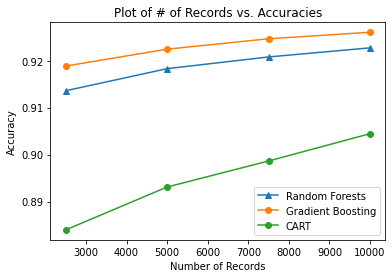

In [14]:
x  = [res[0] for res in results_rf]
y1 = [res[1] for res in results_rf]
y2 = [res[1] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Accuracy")
plt.title("Plot of # of Records vs. Accuracies")
plt.legend()
plt.show()

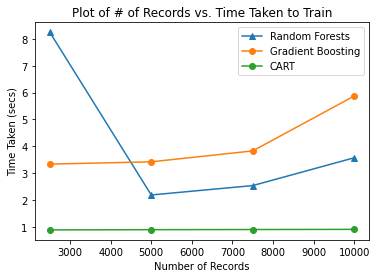

In [15]:
x  = [res[0] for res in results_rf]
y1 = [res[2] for res in results_rf]
y2 = [res[2] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Time Taken (secs)")
plt.title("Plot of # of Records vs. Time Taken to Train")
plt.legend()
plt.show()

In [18]:
cm_acc_per_sec = [res[1] / res[2] for res in results_cm]
print(cm_acc_per_sec)

[1.054522738410369, 0.9073052465499669, 0.6703477992703184, 0.6632711873711861]


In [20]:
gb_acc_per_sec = [res[1] / res[2] for res in results_gb]
print(gb_acc_per_sec)

[0.27554373242136854, 0.26967115524523017, 0.24163666015675866, 0.15774199925697263]


In [21]:
rf_acc_per_sec = [res[1] / res[2] for res in results_rf]
print(rf_acc_per_sec)

[0.11076941266184746, 0.4201190466971037, 0.36315331498622083, 0.2584228877686349]
